<a href="https://colab.research.google.com/github/mvenouziou/Project-Language-Translation/blob/main/text_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural translation model

*Capstone Project for Imperial College London's "Customising your models with TensorFlow 2" course on Coursera.*

The following program is my a translation model to convert English sentences into German. It consists of an RNN encoders and decoders. 



---


*Credits:*

*- This was a course capstone project, where the necessary steps were outlined by the course instructor. RNN diagrams and a small number of functions were provided by the instructor, and are noted as such within their function descriptions. Otherwise, this is my own work based on techniques taught in the course.*

*- Course info: www.coursera.org/account/accomplishments/verify/3X7RJ4S9ZLEK.*

*- The dataset consists of English/German sentence pairs from the Tatoeba Project. *(www.manythings.org/anki)*

*- The encoder utilizes pretrained embeddings from Tensorflow Hub, https://tfhub.dev/google/nnlm-en-dim128/1. They cite Yoshua Bengio, Réjean Ducharme, Pascal Vincent and Christian Jauvin's paper, A Neural Probabilistic Language Model. Journal of Machine Learning Research, 3:1137-1155, 2003.*

In [1]:
# ML
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import ModelCheckpoint 

# pretrained models
import tensorflow_hub as hub
!pip install tensorflow_text -q
import tensorflow_text as text

# data handling
import numpy as np
import pandas as pd
import unicodedata
import re
import string

# visualiztion
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 3.4MB 9.0MB/s 


Global Paramaters

In [2]:
# GLOBAL PARAMATERS
ENGLIGH_SENT_TRUNC = 13
GERMAN_SENT_TRUNC = 16
MAX_GERMAN_VOCAB_SIZE = None  # sets other words to unknown. Does NOT affect final Dense layer
EMBEDDING_DIM = 128
# warning: num examples dramatically affects vocab length, which affects final Dense layer
# keep at around 20,000 or use high RAM environment
NUM_EXAMPLES = 20000 # max possible= 100,000
BATCH_SIZE = 16
MASK_VALUE = 0
LSTM_ACTIVATIONS=512

File paths for data and checkpoints

In [3]:
# Load Google Drive
from google.colab import drive
GDRIVE_DIR ='/content/gdrive/' 
drive.mount(GDRIVE_DIR)

FILEPATH = GDRIVE_DIR + 'MyDrive/Colab_Notebooks/models/text_translation'
CHECKPOINT_DIR = FILEPATH + '/checkpoints/'
CACHE_DIR = FILEPATH + '/cache/'
PREDICTION_MODEL_DIR = FILEPATH + '/prediction_model/'
TRAINING_MODEL_DIR = FILEPATH + '/training_model/'
DATASETS_DIR = FILEPATH + '/datasets/'

Mounted at /content/gdrive/


###Load Dataset

*(Loader function provided by instuctor)*

In [4]:
# Run this cell to load the dataset

def load_text_data(num_examples=NUM_EXAMPLES, filepath= DATASETS_DIR + 'deu.txt'):
    data_examples = []

    with open(filepath, 'r', encoding='utf8') as f:
        for line in f.readlines():
            if len(data_examples) < num_examples:
                data_examples.append(line)
            else:
                break

    return data_examples

In [5]:
data_examples = load_text_data()
data_examples[0].split('\t')[1]

'Hallo!'

###Translation model architecture

*(Diagram of model architecture provided by instructor)*

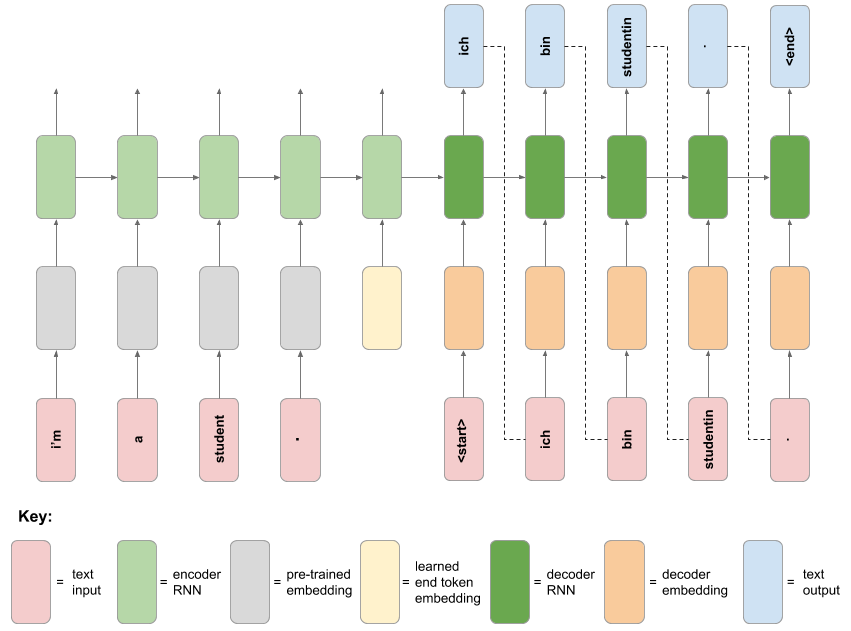

In [6]:
# download / view schematic diagram for the full neural translation model
!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

## 1. Text preprocessing

*Prelimenary text cleanup functions provided by instuctor*

In [7]:
# These functions preprocess English and German sentences
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) 
                    if unicodedata.category(c) != 'Mn')


def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()

    # adjusts for letters that don't appear in English alphabet
    sentence = re.sub(r"ü", 'ue', sentence)  
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

Separate English and German sentences and add start/end tokens to German text

In [8]:
def separate_and_process(tab_delim_data, start_indicator='<SOS>', 
                         end_indicator='<EOS>'):
    
    phrases = {}

    for language in ['English', 'German']:
    
        if language == 'English':
            indx = 0
            start = ''  # not using start / end tokens
            end= ''
        elif language == 'German':
            indx = 1
            start = start_indicator  # start of sentence token
            end = end_indicator  # end of sentence token
        
        phrases[language] = [tab_delim_data[i].split('\t')[indx]
                for i in range(len(tab_delim_data))]

        if language=='German':
            phrases[language]  = \
                [' '.join([start, preprocess_sentence(sentence), end]) 
                 for sentence in phrases[language]]

    return phrases['English'], phrases['German']


Tokenize German sentences

In [9]:
# split words from punctuation and spaces
def separate_on_punc(sometext, tf_version=False):
    pattern = r"[\w']+|[.,!?;]"
    
    if tf_version:
        tokenizer = text.UnicodeScriptTokenizer()
        sometext = tokenizer.tokenize(sometext)

    else:
        sometext = re.findall(pattern, sometext)   
    return sometext


# creating tokenizer vocabulary
def create_vocab(text_list):

    # extract words from text list
    vocab = []
    [vocab.extend(sentence.split(' ')) for sentence in text_list]

    # remove punctionation and drop duplicate words
    vocab = ' '.join(vocab)
    vocab = separate_on_punc(vocab)
    vocab = list(set(vocab))

    # add back in punctuation as individual elements
    punc = separate_on_punc(string.punctuation)
    dig = separate_on_punc(string.digits)
    vocab.extend(punc + dig)
    vocab = [x for x in vocab]
    
    return vocab


# tokenizer for German text. 
# (we'll use pretrained embedding for English text)
def tokenize(phrases, max_vocab_size=MAX_GERMAN_VOCAB_SIZE):
    
    # prepare phrases as text sequences
    phrases_lists = [(separate_on_punc(sentence)) for sentence in phrases]

    # prepare vocabulary
    vocab = create_vocab(phrases)  

    # create and fit tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
                        num_words=max_vocab_size,
                        filters=None,
                        lower=True, 
                        split=' ', 
                        char_level=False, 
                        oov_token='<UKN>',  # for unknown words
                        )
    tokenizer.fit_on_texts([vocab])

    # apply tokenizer
    tokenized_text = tokenizer.texts_to_sequences(phrases_lists) 

    return tokenizer, tokenized_text

Display text examples (English / German / Tokenized German)

In [10]:
num_examples = 5

# extract / prepare phrases
english, german = separate_and_process(data_examples)

# create German tokenizer
german_tokenizer, german_tokenized = tokenize(phrases=german)

# display randomly chosen examples
num_samples = len(english)
rand_ind = np.random.randint(0, high=num_samples, size=num_examples)

tf.print('English', '\t', 'German', '\t\t', 'Germand (tokenized)\n' +
      '--------\t----------------\t-------------------------------')
for indx in range(num_examples):
    tf.print(english[indx], '\t', german[indx], '\t\t', german_tokenized[indx])


English 	 German 		 Germand (tokenized)
--------	----------------	-------------------------------
Hi. 	 <SOS> hallo ! <EOS> 		 [1632, 3413, 5, 3484]
Hi. 	 <SOS> gruess gott ! <EOS> 		 [1632, 2300, 738, 5, 3484]
Run! 	 <SOS> lauf ! <EOS> 		 [1632, 5561, 5, 3484]
Wow! 	 <SOS> potzdonner ! <EOS> 		 [1632, 3296, 5, 3484]
Wow! 	 <SOS> donnerwetter ! <EOS> 		 [1632, 5718, 5, 3484]


Pad German tokenized phrases

In [11]:
def apply_padding(tokenized_text, side='post', max_len=None):
    if max_len is None:
        max_len = 0
        for line in german_tokenized:
            length = len(line)
            if length > max_len:
                max_len = length
    
    # apply padding
    padded_text = tf.keras.preprocessing.sequence.pad_sequences(
                            sequences=tokenized_text, maxlen=max_len, 
                            dtype='int32', padding=side,
                            truncating='pre', value=0.0)  
    
    return padded_text

In [12]:
german_tok_padded = apply_padding(german_tokenized)
tf.print('shape:', german_tok_padded.shape)
tf.print('\n', german_tok_padded)

shape: (20000, 14)

 array([[1632, 3413,    5, ...,    0,    0,    0],
       [1632, 2300,  738, ...,    0,    0,    0],
       [1632, 5561,    5, ...,    0,    0,    0],
       ...,
       [1632,  125, 2662, ...,    0,    0,    0],
       [1632,  125, 3146, ...,    0,    0,    0],
       [1632,  125, 3146, ...,    0,    0,    0]], dtype=int32)


## 2. Prepare the data

Load the embedding layer

In [13]:
# Load embedding module from Tensorflow Hub

try:  # (check if it has already been loaded this session)
    PRETRAINED_EMBEDDING is not None == True
    tf.print('embedding loaded')
except:
    PRETRAINED_EMBEDDING=hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
        output_shape=[EMBEDDING_DIM], input_shape=[], 
        dtype=tf.string)

Prepare the training and validation Datasets.

In [14]:
def prep_dataset(data_examples_tab_delim, test_size=0.20, 
                 english_truncated_size=ENGLIGH_SENT_TRUNC,
                 mask_value=MASK_VALUE, batch_size=BATCH_SIZE,
                 german_pad_length=GERMAN_SENT_TRUNC+2,
                 embedding_layer=PRETRAINED_EMBEDDING,
                 translation_mode=False,
                 verbose=False):

    # function will be used differently in training and translating steps
    # translation mode required params:
    if translation_mode:
        batch_size=1
        german_pad_length=2
        test_size=.5

    # set paramaters
    start_indicator = '<SOS>'
    end_indicator = '<EOS>'

    if verbose:
        tf.print('PRE-PROCESSING DATA')
    english, german = separate_and_process(data_examples_tab_delim, 
                                           start_indicator, end_indicator)
    
    # tokenize and pad German
    if verbose:
        tf.print('Tokenizing German Sentences')
    german_tokenizer, german_tokenized = tokenize(phrases=german)
    german_tok_padded = apply_padding(german_tokenized, 
                                      max_len=german_pad_length)

    # get tokenized value for start/end strings
    start_end = german_tokenizer.texts_to_sequences([
                                [start_indicator.strip(string.punctuation)], 
                                [end_indicator.strip(string.punctuation)]])
    start_token = start_end[0]
    end_token = start_end[1]

    # ###########################
    """ Create a random training and validation set split of the data, 
    reserving e.g. 20% of the data for validation (NB: each English dataset 
    example is a single sentence string, and each German dataset example is 
    a sequence of padded integer tokens)."""

    # separate into train / validation sets
    if verbose:
        print('Creating Test/ Train sets')
    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = \
            train_test_split(english, german_tok_padded,
                             test_size=test_size, shuffle=True)
    if verbose:
        print('')

    # ###########################
    """ Load the training and validation sets into a tf.data.Dataset object, 
    passing in a tuple of English and German data for both 
    training and validation sets."""
    # ###########################

    # convert to TF Datasets
    if verbose:
        print('Creating tensorflow datasets')
    train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(x_train), 
                                                tf.constant(y_train)))
    valid_ds = tf.data.Dataset.from_tensor_slices((tf.constant(x_valid), 
                                                tf.constant(y_valid)))
    if verbose:
        print('Train:', train_ds.element_spec, '\nValid:', valid_ds.element_spec)
        print('')

    # ###########################
    """Create a function to map over the datasets that splits each 
    English sentence at spaces. Apply this function to both Dataset objects 
    using the map method. Hint: look at the tf.strings.split function."""
    # ###########################

    # split English sentences on spaces
    if verbose:
        print('Splitting English Sentences')
    @tf.function
    def split_x(x, y):
        split = tf.strings.split(x)  
        return split, y

    train_ds = train_ds.map(split_x)
    valid_ds = valid_ds.map(split_x)
    if verbose:
        print('- Train:', train_ds.element_spec, '\n- Valid:', valid_ds.element_spec)
        print('')

    # ###########################
    """Create a function to map over the datasets that embeds each sequence 
    of English words using the loaded embedding layer/model. 
    Apply this function to both Dataset objects using the map method."""
    # ###########################

    # Load pretrained embedding and apply to English text
    if verbose:
        print('Embedding English sentences')
    # Applying pretrained embedding to English sentences
    @tf.function
    def embed_x(x, y):
        x = embedding_layer(x)
        return x, y

    train_ds = train_ds.map(embed_x)
    valid_ds = valid_ds.map(embed_x)
    if verbose:
        print('- Train:', train_ds.element_spec, '\n- Valid:', valid_ds.element_spec)
        print('')

    # ###########################
    """Create a function to filter out dataset examples where the English 
    sentence is greater than or equal to than 13 (embedded) tokens in length. 
    Apply this function to both Dataset objects using the filter method."""
    # ###########################

    # filter out long English sentences ( > english_truncated_size)
    if verbose:
        print(f'Removing samples with long English sentences (> {english_truncated_size -2})')
    @tf.function
    def filter_x(x, y):
        return len(x) <= english_truncated_size -2

    train_ds = train_ds.filter(filter_x)
    valid_ds = valid_ds.filter(filter_x)
    if verbose:
        print('- Train:', train_ds.element_spec, '\n- Valid:', valid_ds.element_spec)
        print('')

    # ###########################
    """Create a function to map over the datasets that pads each English 
    sequence of embeddings with some distinct padding value before the sequence,
     so that each sequence is length 13. Apply this function to both Dataset 
     objects using the map method. Hint: look at the tf.pad function. You can 
     extract a Tensor shape using tf.shape; you might also find the 
     tf.math.maximum function useful."""
    # ###########################

    # pad English to uniform length
    if verbose:
        print(f'Padding English sentences (length = {english_truncated_size})')
    @tf.function
    def pad_x(x, y):
        length = len(x)
        pad_needed = tf.maximum(0, english_truncated_size - length)
        x = tf.pad(x, ([pad_needed,0], [0,0]), constant_values=mask_value)
        return x, y

    train_ds = train_ds.map(pad_x)
    valid_ds = valid_ds.map(pad_x)
    if verbose:
        print('- Train:', train_ds.element_spec, '\n- Valid:', valid_ds.element_spec)
        print('')

    # ###########################
    """Batch both training and validation Datasets with a batch size of 16."""
    # ###########################

    # Batch datasets
    if verbose:
        print(f'Batching datasets, batch_size: {batch_size}')
    train_ds = train_ds.batch(batch_size)
    valid_ds = valid_ds.batch(batch_size)
    if verbose:
        print('- Train:', train_ds.element_spec, '\n- Valid:', valid_ds.element_spec)
        print('')

    return train_ds, valid_ds, german_tokenizer, start_token, end_token


Print DS and example shapes

In [15]:
""" Print the element_spec property for the training and validation Datasets.
Using the Dataset .take(1) method, print the shape of the English data example 
from the training Dataset. Using the Dataset .take(1) method, print the German 
data example Tensor from the validation Dataset.. """
train_ds, valid_ds, german_tokenizer, start_token, end_token = \
    prep_dataset(data_examples, batch_size=16, test_size=.2, verbose=True)

print('Train DS:', train_ds.element_spec)
print('Validation DS:', valid_ds.element_spec)
print()
print('English example shape:', next(train_ds.take(1).as_numpy_iterator())[0].shape)
print('German example shape:', next(train_ds.take(1).as_numpy_iterator())[1].shape)

PRE-PROCESSING DATA
Tokenizing German Sentences
Creating Test/ Train sets

Creating tensorflow datasets
Train: (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(18,), dtype=tf.int32, name=None)) 
Valid: (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(18,), dtype=tf.int32, name=None))

Splitting English Sentences
- Train: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(18,), dtype=tf.int32, name=None)) 
- Valid: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(18,), dtype=tf.int32, name=None))

Embedding English sentences
- Train: (TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(18,), dtype=tf.int32, name=None)) 
- Valid: (TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(18,), dtype=tf.int32, name=None))

Removing samples with long English sentences (> 11)
- Train: (TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(sha

Display German tensor example:

In [16]:
print('German example:', next(valid_ds.take(1).as_numpy_iterator())[1])

German example: [[1632 1168 4399 3292  570    3 3484    0    0    0    0    0    0    0
     0    0    0    0]
 [1632 2662 4465   81    3 3484    0    0    0    0    0    0    0    0
     0    0    0    0]
 [1632 4673 1262 3231  690    3 3484    0    0    0    0    0    0    0
     0    0    0    0]
 [1632  125 2513 5562 1262    3 3484    0    0    0    0    0    0    0
     0    0    0    0]
 [1632 2155    5 3484    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [1632  125 2662 3463 5337    3 3484    0    0    0    0    0    0    0
     0    0    0    0]
 [1632 2363 5562 3706    5 3484    0    0    0    0    0    0    0    0
     0    0    0    0]
 [1632  125 2662  757 5533    3 3484    0    0    0    0    0    0    0
     0    0    0    0]
 [1632 1096 1262 2051    3 3484    0    0    0    0    0    0    0    0
     0    0    0    0]
 [1632 4349 4383  475    3 3484    0    0    0    0    0    0    0    0
     0    0    0    0]
 [1632  125 2662 5403 4869    3 34

## 3. Create the custom layer

*(Diagram of encoder architecture provided by instructor)*

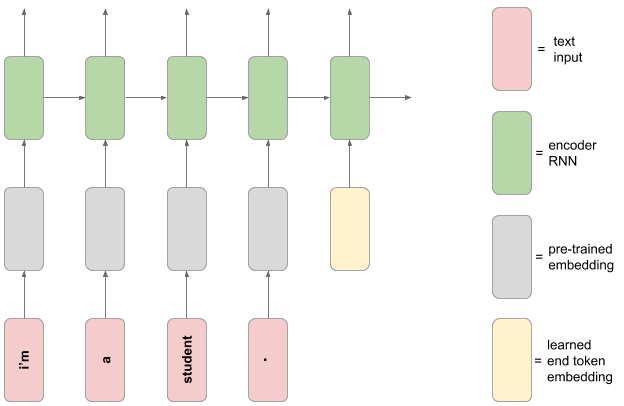

In [17]:
# download / view a schematic diagram for the encoder model
!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

Create custom layer that appends a trainable variable to the end of each English example. This is a learned 'end of sentence' value.

In [18]:
class AppendVarLayer(Layer):

    def __init__(self, embedding_dim=EMBEDDING_DIM, batch_size=BATCH_SIZE, *kwargs):
        super().__init__()

        # attributes
        self.embedding_dim = embedding_dim
        self.batch_size=batch_size 

        # trainable variable
        self.w = tf.Variable(initial_value=tf.random.normal(
                            shape=[1, 1, self.embedding_dim], 
                            mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
                                            ),
                             trainable=True)
                
    def call(self, inputs):
        # expand to match batched input shape
        w_stacked = tf.tile(self.w, [self.batch_size, 1 ,1])

        return tf.concat([inputs, w_stacked], axis=1)


In [19]:
"""Using the Dataset .take(1) method, extract a batch of English data examples 
from the training Dataset and print the shape. Test the custom layer 
by calling the layer on the English data batch Tensor 
and print the resulting Tensor shape (the layer should increase 
the sequence length by one)."""

# get element
x = train_ds.take(1)
x = next(x.as_numpy_iterator())[0]
print('layer input shape:', x.shape)

# test layer
layer = AppendVarLayer()
x_out = layer(x)
print('layer output shape:', tf.shape(x_out))

layer input shape: (16, 13, 128)
layer output shape: tf.Tensor([ 16  14 128], shape=(3,), dtype=int32)


## 4. Build the encoder network

In [20]:
def EncoderModel(embedding_dim=EMBEDDING_DIM, batch_size=BATCH_SIZE,
                     mask_value=MASK_VALUE, input_words=ENGLIGH_SENT_TRUNC,
                     verbose=False):
    
    from tensorflow.keras import Model, Input
    from tensorflow.keras.layers import Masking, LSTM, Lambda, Concatenate

    # get inputs
    inputs = Input(shape=(input_words, embedding_dim), batch_size=batch_size, 
              name='Input_English')
    x = inputs
    
    # model architecture
    x = AppendVarLayer(batch_size=batch_size)(x)  # appends trainable variable to end of sequence
    x = Masking(mask_value=mask_value, name='Mask')(x)
    x = LSTM(units=LSTM_ACTIVATIONS, return_state=True, name='LSTM_1')(x)
    # note: LSTM output = seq_output, final_memory_state, final_carry_state

    # define outputs
    outputs = (x[1], x[2])  # drops x[0], only internal states used for encoding

    # create model
    model = Model(inputs=inputs, outputs=outputs, name="English_Encoder")

    if verbose:
        print(model.summary())

    return model



Tensor Shapes

In [21]:
"""Using the Dataset .take(1) method, extract a batch of English data examples 
from the training Dataset and test the encoder model by calling it 
on the English data Tensor, and print the shape of the resulting Tensor outputs.
"""

# get model
eng_enc_model = EncoderModel(verbose=False)
# get data batch
x = train_ds.take(1)
# apply model
out = eng_enc_model.predict(x)
print('output shape_0:', tf.shape(out[0]),
      '\noutput shape_1:', tf.shape(out[1])
    )

output shape_0: tf.Tensor([ 16 512], shape=(2,), dtype=int32) 
output shape_1: tf.Tensor([ 16 512], shape=(2,), dtype=int32)


In [22]:
"""Print the model summary for the encoder network."""
eng_enc_model.summary()

Model: "English_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_English (InputLayer)   [(16, 13, 128)]           0         
_________________________________________________________________
append_var_layer_1 (AppendVa (16, 14, 128)             128       
_________________________________________________________________
Mask (Masking)               (16, 14, 128)             0         
_________________________________________________________________
LSTM_1 (LSTM)                [(16, 512), (16, 512), (1 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network

*(Diagram of decoder architecture provided by instructor)*

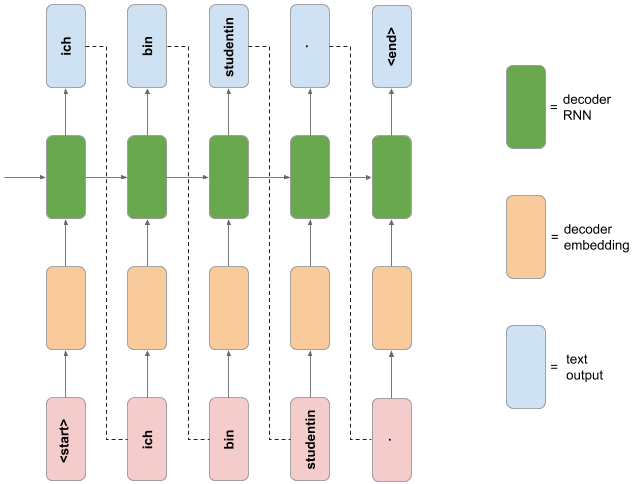

In [23]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

Build the RNN decoder model

In [24]:
GERMAN_VOCAB_SIZE = 1 + len(german_tokenizer.word_counts)
class DecoderModel(tf.keras.Model):
    
    def __init__(self, name='German_Decoder', 
                 embedding_dim=EMBEDDING_DIM, 
                 vocab_size=GERMAN_VOCAB_SIZE, 
                 hidden_state=None, cell_state=None,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.hidden_state = hidden_state 
        self.cell_state = cell_state

        from tensorflow.keras.layers import Embedding, LSTM, Dense
        
        self.embedding = Embedding(input_dim=vocab_size, 
                                   output_dim=embedding_dim, 
                                   mask_zero=True)
        self.LSTM_1 = LSTM(units=LSTM_ACTIVATIONS,
                           return_state=True, return_sequences=True)
        self.Dense_1 = Dense(units=vocab_size, activation=None)  # maps to German word tokens

    def call(self, inputs, initial_state=None, verbose=False, **kwargs):
        # Inputs
        x = inputs

        #architecture
        # ## embedding
        x = self.embedding(x)       

        # ## LSTM
        x, hidden_state, cell_state = \
            self.LSTM_1(x, initial_state=initial_state)
            
        # ## Dense
        x = self.Dense_1(x)

        # Outputs
        initial_state = [hidden_state, cell_state]
        outputs = x, initial_state

        if verbose:
            print('x:', tf.shape(x))
            print('hidden_state:', tf.shape(hidden_state))
            print('cell_state:', tf.shape(cell_state))

        return outputs

Decoder Output Shapes

In [25]:
"""Using the Dataset .take(1) method, extract a batch of English and German 
data examples from the training Dataset. Test the decoder model by first calling
the encoder model on the English data Tensor to get the hidden and cell states,
and then call the decoder model on the German data Tensor and hidden and cell 
states, and print the shape of the resulting decoder Tensor outputs."""

decoder = DecoderModel()
encoder = EncoderModel()

x = next(train_ds.take(1).as_numpy_iterator())[0]
x = encoder(x)

start = next(train_ds.take(1).as_numpy_iterator())[1]
x, initial_state = decoder(start, x, verbose=False)

print(f'output tensor shape: {tf.shape(x)}\n\
initial_state: {tf.shape(initial_state[0])}, {tf.shape(initial_state[1])}')

output tensor shape: [  16   18 5748]
initial_state: [ 16 512], [ 16 512]


Decoder Model summary

In [26]:
# show decoder model summary
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735744    
_________________________________________________________________
lstm (LSTM)                  multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2948724   
Total params: 4,997,236
Trainable params: 4,997,236
Non-trainable params: 0
_________________________________________________________________


## 6. Custom training loop

In [27]:
"""
Define a function that takes a Tensor batch of German data 
(as extracted from the training Dataset), and returns a tuple 
containing German inputs and outputs for the decoder model 
(refer to schematic diagram above).
"""
@tf.function
def german_input_output(y):
    inp = y[:, :-1]  # drop last word ('end token')
    out = y[:, 1:]  # drop forst word ('start token')

    return inp, out


Define Model's Forward / Backward Passes

In [28]:
"""
Define a function that computes the forward and backward pass 
for your translation model. This function should take an English input, 
German input and German output as arguments, and should do the following:
"""
from tensorflow.keras.utils import to_categorical

@tf.function
def training_step(english_input, german_input, german_output, 
               encoder_model, decoder_model, optimizer,
               compute_grads=True,
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
               ):
    
    with tf.GradientTape() as tape:
        # encoding English inputs
        initial_state = encoder_model(english_input)  

        # decoding predicted German ouputs
        predictions, hidden_states = \
            decoder_model(german_input, initial_state)

        # compute losses
        losses = loss(german_output, predictions)

        # compute gradients
        if compute_grads:
            trainables = encoder_model.trainable_variables + \
                            decoder_model.trainable_variables
            grads = tape.gradient(losses, trainables)
        else:
            grads=None

        # update model weights            
        if compute_grads:
            optimizer.apply_gradients(
                    zip(grads, encoder_model.trainable_variables +
                                    decoder_model.trainable_variables))
        
        return grads, predictions, losses


# Track Metrics
def track_metrics(loss_tracker, auc_tracker, german_output, predictions, losses):

    # track metric: losses
    if loss_tracker is not None:
        loss_tracker.update_state(losses)
    
    # track metric: AUC auc
    if auc_tracker is not None:
        y_true = to_categorical(y=german_output, num_classes=GERMAN_VOCAB_SIZE)
        auc_tracker.update_state(y_true, tf.math.sigmoid(predictions))

    return loss_tracker, auc_tracker

In [29]:
# End of Epoch cleanup: 
def epoch_results(batch_losses_tracker, batch_auc_tracker,
                  epoch_losses_list, epoch_auc_list):
    
    # compute epoch results
    ave_loss = batch_losses_tracker.result()
    ave_auc = batch_auc_tracker.result()

    # update lists
    epoch_losses_list += [ave_loss]  #  avoiding append for @tf.function
    epoch_auc_list += [ave_auc]

    # reset trackers
    batch_losses_tracker.reset_states()
    batch_auc_tracker.reset_states()

    return batch_losses_tracker, batch_auc_tracker

Define Training Loop

In [30]:
def train_loop(train_ds, valid_ds, num_epochs, train_steps, val_steps,
               encoder_model, decoder_model, 
               encoder_checkpoint_manager, decoder_checkpoint_manager):
    
    # for converstion from sparce to standard categories

    # define loss and optimizers
    loss_metric = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    
    # define metrics
    # metric: loss
    train_losses = []
    valid_losses = []
    batch_train_losses = tf.keras.metrics.Mean()
    batch_valid_losses = tf.keras.metrics.Mean()

    # metric: AUC (illustrates precision-recall)
    train_AUC = []
    valid_AUC = []
    batch_train_AUC = tf.keras.metrics.AUC(curve='ROC')
    batch_valid_AUC = tf.keras.metrics.AUC(curve='ROC')

    for epoch in range(num_epochs):
        tf.print(f'epoch: {epoch}')

        # shuffle data
        train_ds = train_ds.shuffle(buffer_size=10*train_steps)
        valid_ds = valid_ds.shuffle(buffer_size=10*train_steps)

        # Training Loop       
        batch = 0       
        for english, german in train_ds.take(train_steps):

            # get decoder input/outputs
            german_input, german_output = german_input_output(german)

            # update training batch grads, loss_tracker, auc_tracker
            grads, predictions, losses = \
                    training_step(english_input=english, 
                               german_input=german_input, 
                               german_output=german_output, 
                               encoder_model=encoder_model, 
                               decoder_model=decoder_model, 
                               optimizer=optimizer,
                               compute_grads=True,  # training
                               loss=loss_metric)  
                    
            batch_train_losses, batch_train_AUC = \
                track_metrics(batch_train_losses, batch_train_AUC,  # training
                              german_output, predictions, losses)
                                   
            checkpoint_freq = 4
            if batch % train_steps//checkpoint_freq == 0:
                
                # report progress
                print('train_loss:', batch_train_losses.result())
                print('train_auc:', batch_train_AUC.result())

                # save checkpoint
                encoder_checkpoint_manager.save()
                decoder_checkpoint_manager.save()

            # update batch number
            batch += 1

        # End of train epoch steps:
        # save checkpoint
        encoder_checkpoint_manager.save()
        decoder_checkpoint_manager.save()

        # record epoch results (training)
        epoch_results(batch_train_losses,  # training
                      batch_train_AUC,  # training
                      epoch_losses_list=train_losses,   # training
                      epoch_auc_list=train_AUC)  # training

        # get validation data
        for english, german in valid_ds.take(val_steps):

            # get decoder input/outputs
            german_input, german_output = german_input_output(german)

            # update validation's loss_tracker, auc_tracker
            _, predictions, losses = \
                training_step(english, 
                        german_input, 
                        german_output, 
                        encoder_model, 
                        decoder_model, 
                        optimizer=None,  # no training on validation set
                        compute_grads=False,  # no training on validation set
                        loss=loss_metric)  
            
            batch_valid_losses, batch_valid_AUC = \
                track_metrics(batch_valid_losses, batch_valid_AUC,  # validation
                              german_output, predictions, losses)

        # End of validation epoch steps:
        # report epoch validation results
        print('- val_loss:', batch_valid_losses.result())
        print('  val_auc:', batch_valid_AUC.result())

        # record epoch results (validation)
        epoch_results(batch_valid_losses,  # validation
                      batch_valid_AUC,  # validation
                      epoch_losses_list=valid_losses,   # validation
                      epoch_auc_list=valid_AUC)  # validation
    
    # prepare outputs
    losses = [train_losses, valid_losses]
    auc = [train_AUC, valid_AUC]

    return  encoder_model, decoder_model, losses, auc

Define model loader

In [31]:
def model_load_init(model_class, start_fresh=False):
    # use model_class = EncoderModel or DecoderModel

    # set model's checkpoint paramaters
    if model_class == EncoderModel:
        name = 'encoder'
    
    elif model_class == DecoderModel:
        name = 'decoder'

    # initialize model architecture
    model = model_class()

    # load checkpoint
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint_manager = tf.train.CheckpointManager(
                            checkpoint=checkpoint, 
                            directory=CHECKPOINT_DIR, 
                            max_to_keep=2, 
                            keep_checkpoint_every_n_hours=None,
                            checkpoint_name=name + '.ckpt',
                            step_counter=None, 
                            checkpoint_interval=None,
                            init_fn=None
                            )
    if start_fresh:
        tf.print(f'new {name} model initialized')

    else:  # load saved weights if available
        try:
            checkpoint_manager.restore_or_initialize()
            tf.print(f'loaded saved {name} model')
        except:
            tf.print(f'new {name} model initialized')

    return model, checkpoint, checkpoint_manager

# Implement Training Functions

Load / Initialize Models

In [32]:
# initialize encoder
encoder_model, encoder_checkpoint, encoder_checkpoint_manager = \
    model_load_init(model_class=EncoderModel, start_fresh=False)

# initialize decoder
decoder_model, decoder_checkpoint, decoder_checkpoint_manager = \
    model_load_init(model_class=DecoderModel, start_fresh=False)

loaded saved encoder model
loaded saved decoder model


Implement Training Loop

In [33]:
train_model = True
# train models
#** note: this only uses a small subset of values from the sample set 
# for illustration purposes **
num_epochs = 20
val_steps = 25
train_steps = 1000  # make sure to use this because of extremely large dataset

if train_model:
    encoder_model, decoder_model, losses, auc = \
        train_loop(train_ds, valid_ds, 
                   num_epochs=num_epochs, 
                   train_steps=train_steps, 
                   val_steps=val_steps,
                   encoder_model=encoder_model, 
                   decoder_model=decoder_model,
                   encoder_checkpoint_manager=encoder_checkpoint_manager, 
                   decoder_checkpoint_manager=decoder_checkpoint_manager)

epoch: 0
train_loss: tf.Tensor(7.108843, shape=(), dtype=float32)
train_auc: tf.Tensor(0.796377, shape=(), dtype=float32)
train_loss: tf.Tensor(8.687534, shape=(), dtype=float32)
train_auc: tf.Tensor(0.72913325, shape=(), dtype=float32)
train_loss: tf.Tensor(9.152596, shape=(), dtype=float32)
train_auc: tf.Tensor(0.70108587, shape=(), dtype=float32)
train_loss: tf.Tensor(9.254087, shape=(), dtype=float32)
train_auc: tf.Tensor(0.6866429, shape=(), dtype=float32)
- val_loss: tf.Tensor(3.2460952, shape=(), dtype=float32)
  val_auc: tf.Tensor(0.9747721, shape=(), dtype=float32)
epoch: 1
train_loss: tf.Tensor(3.204714, shape=(), dtype=float32)
train_auc: tf.Tensor(0.97905624, shape=(), dtype=float32)
train_loss: tf.Tensor(3.1503453, shape=(), dtype=float32)
train_auc: tf.Tensor(0.9805777, shape=(), dtype=float32)
train_loss: tf.Tensor(3.1487057, shape=(), dtype=float32)
train_auc: tf.Tensor(0.9846087, shape=(), dtype=float32)
train_loss: tf.Tensor(3.168926, shape=(), dtype=float32)
train_au

Training Plots

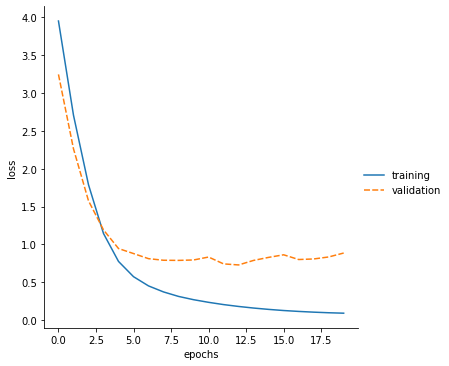

In [34]:
# Loss Plot
df = pd.DataFrame(np.array(losses).T, columns=['training', 'validation'])
df.index.name='epoch'
plots = sns.relplot(data=df, kind='line')
plots.set_axis_labels('epochs', 'loss')

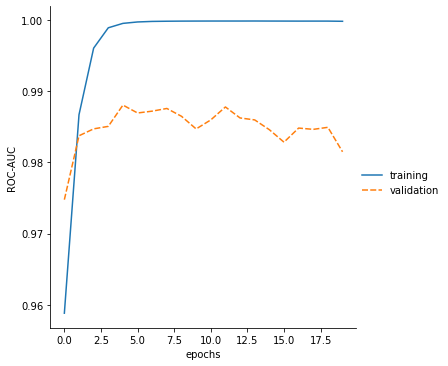

In [35]:
# ROC-AUC Plot
df = pd.DataFrame(np.array(auc).T, columns=['training', 'validation'])
df.index.name='epoch'
plots = sns.relplot(data=df, kind='line')
plots.set_axis_labels('epochs', 'ROC-AUC')

## 7. Implement final translation model

Translation function

In [36]:
def translate(english_text, max_german_words, encoder_model, decoder_model,
              german_tokenizer):
    # note: use batch_size 1 in encoder/decoders!

    # prepare text for preprocessor
    tab_data = [''.join([english_text,'\t']),  # repeat sample twice 
                ''.join([english_text,'\t'])]  # because one is used in validation split 

    # prepare text for encoder
    # (note: make sure to suppress the tokenizer this normally produces 
    # b/c it might not match the tokenizer model was trained with)
    train_ds, _, _, start_token, end_token = \
        prep_dataset(tab_data, translation_mode=True)

    translation_tokens = []

    # Get first German word translation
    for english, german in train_ds:  # train_ds only contains one entry

        # encode English inputs
        initial_states = encoder_model(english)  

        # get decoder input for <SOS> to initialize translation loop
        german_input, _ = german_input_output(german)

    # generate words
    for word in range(max_german_words): 
        
        # decoding predicted German ouputs
        predictions, initial_states = \
            decoder_model(german_input, initial_states)

        #print(predictions)

        # choose highest probability word
        indx = np.argmax(predictions[0, 0, :])
        translation_tokens.append(int(indx))

        # cue chosen word as input for next translation step 
        german_input = tf.constant([[indx]])

        # early stopping condition: end of sentence token produced
        if indx == end_token:
            translation_tokens = translation_tokens[:-1]  # drop end token
            break  # exit loop

    # decode german tokens to text
    translation_tokens = list([translation_tokens])
    print(translation_tokens)
    translation = german_tokenizer.sequences_to_texts(translation_tokens)
  
    return  translation[0]

Load models

In [37]:
# initialize prediction models (batch size 1)
# encoder model required specified bacth size = 1
encoder_model_predictor = EncoderModel(batch_size=1)
decoder_model_predictor = decoder_model  # original model works

# transfer trained weights to encoder prediction model
enc_trained_weights = encoder_model.get_weights()
encoder_model_predictor.set_weights(enc_trained_weights)

# save prediction models
encoder_model_predictor.save(PREDICTION_MODEL_DIR + 'encoder/')
decoder_model_predictor.save(PREDICTION_MODEL_DIR + 'decoder/')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab_Notebooks/models/text_translation/prediction_model/encoder/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab_Notebooks/models/text_translation/prediction_model/encoder/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab_Notebooks/models/text_translation/prediction_model/decoder/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab_Notebooks/models/text_translation/prediction_model/decoder/assets


In [38]:
# pick 5 examples
num_samples = 5
import random
indices = random.sample(range(len(english)), num_samples)

In [39]:
# translate some examples
for indx in indices:
    english_text = english[indx]
    true_translation = german[indx]
    machine_translation = translate(english_text, 
                                    max_german_words=20, 
                                    encoder_model=encoder_model_predictor, 
                                    decoder_model=decoder_model_predictor,
                                    german_tokenizer=german_tokenizer)
    
    print(f'English: {english_text}\nTranslation: {machine_translation}\n' + \
          f'Actual: {true_translation}\n')

[[2912, 4059, 3939]]
English: You learn fast.
Translation: ihr du ruhig
Actual: <SOS> du lernst schnell . <EOS>

[[125, 2662, 757, 1529]]
English: I'm not a teacher.
Translation: ich bin kein heiliger
Actual: <SOS> ich bin kein lehrer . <EOS>

[[125, 3146, 5253, 1222, 2744]]
English: I took off my hat.
Translation: ich habe meinen platz gebracht
Actual: <SOS> ich habe meinen hut abgenommen . <EOS>

[[4181, 3062, 2552, 1282, 2997]]
English: Give Tom a drink.
Translation: gib tom etwas zu trinken
Actual: <SOS> gib tom etwas zu trinken . <EOS>

[[125, 3146, 5015, 4699]]
English: I have a cold.
Translation: ich habe einen schnupfen
Actual: <SOS> ich bin erkaeltet . <EOS>

